# import pvlib library

In [1]:
import sys
import os
sys.path.append(os.path.abspath('../')) #append the parent directory to the system path
sys.path.append(os.path.abspath('../pvlib')) #append the parent directory to the system path
import pvlib as pvlib
import pandas as pd 
import numpy as np
import datetime

# Import TMY data

## Use Sandia standard data 

In [2]:

fname='../../pvlib/data/723650TYA.csv' #Use absolute path if the file is not in the local directory
TMY, meta = pvlib.tmy.readtmy3(filename=fname)
print(TMY.columns)
print(meta)

Index([u'ETR', u'ETRN', u'GHI', u'GHISource', u'GHIUncertainty', u'DNI',
       u'DNISource', u'DNIUncertainty', u'DHI', u'DHISource',
       u'DHIUncertainty', u'GHillum', u'GHillumSource', u'GHillumUncertainty',
       u'DNillum', u'DNillumSource', u'DNillumUncertainty', u'DHillum',
       u'DHillumSource', u'DHillumUncertainty', u'Zenithlum',
       u'ZenithlumSource', u'ZenithlumUncertainty', u'TotCld', u'TotCldSource',
       u'TotCldUnertainty', u'OpqCld', u'OpqCldSource', u'OpqCldUncertainty',
       u'DryBulb', u'DryBulbSource', u'DryBulbUncertainty', u'DewPoint',
       u'DewPointSource', u'DewPointUncertainty', u'RHum', u'RHumSource',
       u'RHumUncertainty', u'Pressure', u'PressureSource',
       u'PressureUncertainty', u'Wdir', u'WdirSource', u'WdirUncertainty',
       u'Wspd', u'WspdSource', u'WspdUncertainty', u'Hvis', u'HvisSource',
       u'HvisUncertainty', u'CeilHgt', u'CeilHgtSource', u'CeilHgtUncertainty',
       u'Pwat', u'PwatSource', u'PwatUncertainty', u'AOD',

In [3]:
# meta['longitude']=-79.2
# meta['latitude']=43.42
# meta['TZ']=-5
meta['SurfTilt']=30
meta['SurfAz']=0
meta['Albedo']=0.2

location = pvlib.location.Location(latitude=43.42, longitude=-79.2, tz='US/Mountain', altitude=100,
                 name=meta['Name'])

print(location)

"ALBUQUERQUE INTL ARPT [ISIS]": latitude=43.42, longitude=-79.2, tz=US/Mountain, altitude=100


In [4]:
print meta['State']
# print meta['longitude']
print(location)

NM
"ALBUQUERQUE INTL ARPT [ISIS]": latitude=43.42, longitude=-79.2, tz=US/Mountain, altitude=100


## Define date range of interest for graphing

In [5]:
month=3
day=26
hour=0
periods=24
freq='H'
rng=pd.date_range(datetime.datetime(year=min(TMY.index.year),month=month,day=day,hour=hour),periods=periods,freq=freq)
rng                

DatetimeIndex(['1979-03-26 00:00:00', '1979-03-26 01:00:00',
               '1979-03-26 02:00:00', '1979-03-26 03:00:00',
               '1979-03-26 04:00:00', '1979-03-26 05:00:00',
               '1979-03-26 06:00:00', '1979-03-26 07:00:00',
               '1979-03-26 08:00:00', '1979-03-26 09:00:00',
               '1979-03-26 10:00:00', '1979-03-26 11:00:00',
               '1979-03-26 12:00:00', '1979-03-26 13:00:00',
               '1979-03-26 14:00:00', '1979-03-26 15:00:00',
               '1979-03-26 16:00:00', '1979-03-26 17:00:00',
               '1979-03-26 18:00:00', '1979-03-26 19:00:00',
               '1979-03-26 20:00:00', '1979-03-26 21:00:00',
               '1979-03-26 22:00:00', '1979-03-26 23:00:00'],
              dtype='datetime64[ns]', freq='H', tz=None)

# Get solar angles

In [6]:
# import pvlib.solarposition
# reload(pvlib.solarposition)
# print(meta, type(meta))
#Using Ephemeris Calculations
# TMY['SunAz'],TMY['SunEl'],TMY['ApparentSunEl'],TMY['SolarTime'], TMY['SunZen'] = \
#      pvlib.solarposition.ephemeris(time=TMY.index,location=location)
df_ephemeris= pvlib.solarposition.ephemeris(time=TMY.index,location=location)
# print(df_ephemeris)    
TMY['SunAz'] = df_ephemeris['azimuth']
TMY['SunEl'] = df_ephemeris['elevation']
TMY['ApparentSunEl'] =  df_ephemeris['apparent_elevation']
TMY['SolarTime'] = df_ephemeris['solar_time']
TMY['SunZen'] =  df_ephemeris['zenith']
    
#Using NRELS SPA Calculations
# import pvl_spa
# reload (pvl_spa)
# TMY['SunAz_spa'],TMY['SunEl_spa'],TMY['SunZen_spa']=\
#     pvl_spa.pvl_spa(Time=TMY.index,Location=meta)

dfout = pvlib.spa.solar_position(unixtime=TMY.index.astype(np.int64) // 10**9, lat=location.latitude, lon=location.longitude, 
                    elev=location.altitude, 
                    pressure=101325, temp=12, delta_t=67.0, atmos_refract=0.5667)

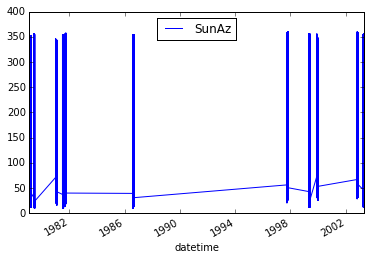

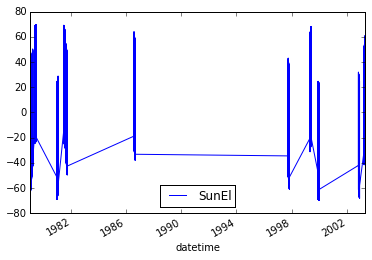

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

pd.DataFrame(TMY.SunAz, index=TMY.index).plot()
# pd.DataFrame(TMY.SunAz_spa, index=TMY.index).plot()
pd.DataFrame(TMY.SunEl, index=TMY.index).plot()
# pd.DataFrame(TMY.SunEl_spa, index=TMY.index).plot()


# Calculate Extraterrestrial Irradiation and AirMass

In [8]:

TMY['HExtra'] = pvlib.irradiance.extraradiation(datetime_or_doy=TMY.index.dayofyear)

TMY['airmass'] = pvlib.atmosphere.relativeairmass(zenith=TMY.SunZen)

pvlib.atmosphere.relativeairmass: zenith input z  #cjwcjw
datetime
1981-01-01 01:00:00-07:00    141.389811
1981-01-05 05:00:00-07:00     98.866129
1981-01-09 09:00:00-07:00     68.259455
1981-01-13 13:00:00-07:00     73.853249
1981-01-17 17:00:00-07:00    109.817971
1981-01-21 21:00:00-07:00    149.923583
1981-01-26 01:00:00-07:00    139.912382
1981-01-30 05:00:00-07:00     96.773064
1979-02-03 09:00:00-07:00     63.479231
1979-02-07 13:00:00-07:00     67.895549
1979-02-11 17:00:00-07:00    104.743360
1979-02-15 21:00:00-07:00    143.440406
1979-02-20 01:00:00-07:00    134.340307
1979-02-24 05:00:00-07:00     91.219278
1979-02-28 09:00:00-07:00     55.301956
1979-03-04 13:00:00-07:00     60.464320
1979-03-08 17:00:00-07:00     99.180760
1979-03-12 21:00:00-07:00    135.417486
1979-03-17 01:00:00-07:00    125.836076
1979-03-21 05:00:00-07:00     83.430885
1979-03-25 09:00:00-07:00     45.571169
1979-03-29 13:00:00-07:00     53.175527
2003-04-02 17:00:00-07:00     93.660226
2003-04-06 21

# Generate Clear Sky and DNI

In [9]:
DFOut = pvlib.irradiance.disc(ghi=TMY.GHI, zenith=TMY.SunZen, times=TMY.index)

TMY['DNI_gen_DISC'] = DFOut['dni']
TMY['Kt_gen_DISC'] = DFOut['kt']
TMY['airmass'] = DFOut['airmass']
# TMY['Ztemp'] = DFOut['Ztemp']

# Plane Transformation

In [10]:
TMY['In_Plane_SkyDiffuse'] = pvlib.irradiance.perez(surface_tilt=meta['SurfTilt'],
                                            surface_azimuth=meta['SurfAz'],
                                            dhi=TMY.DHI,
                                            dni=TMY.DNI,
                                            dni_extra=TMY.HExtra,
                                            solar_zenith=TMY.SunZen,
                                            solar_azimuth=TMY.SunAz,
                                            airmass=TMY.airmass)

# Ground Diffuse reflection

In [11]:
TMY['poa_ground_diffuse'] = pvlib.irradiance.grounddiffuse(surface_tilt=meta['SurfTilt'], ghi=TMY.GHI, albedo=meta['Albedo'],)

# Get AOI

In [12]:
TMY['AOI']=pvlib.irradiance.aoi(surface_tilt=meta['SurfTilt'], surface_azimuth=meta['SurfAz'], 
                                solar_zenith=TMY.SunZen, solar_azimuth=TMY.SunAz)

# Calculate Global in-plane

In [13]:
globalinplane = pvlib.irradiance.globalinplane(aoi=TMY.AOI,
                                dni=TMY.DNI,
                                poa_sky_diffuse=TMY.In_Plane_SkyDiffuse,
                                poa_ground_diffuse=TMY.poa_ground_diffuse)
#                                 SurfTilt=meta['SurfTilt'],
#                                 SurfAz=meta['SurfAz'])

TMY['E'] = globalinplane.poa_global
TMY['Eb'] = globalinplane.poa_direct
TMY['EDiff']= globalinplane.poa_diffuse

# print(TMY['E'])
# print(TMY['Eb'])
# print(TMY['EDiff'])


# Calculate Cell Temperature

In [14]:
# print(TMY.E)
sapm_celltemp = pvlib.pvsystem.sapm_celltemp(irrad=TMY.E,
                            wind=TMY.Wspd,
                            temp=TMY.DryBulb)
print(sapm_celltemp)

TMY['Tcell'] = sapm_celltemp.temp_cell
TMY['Tmodule'] = sapm_celltemp.temp_module

                           temp_cell  temp_module
datetime                                         
1981-01-01 01:00:00-07:00        NaN          NaN
1981-01-01 02:00:00-07:00        NaN          NaN
1981-01-01 03:00:00-07:00        NaN          NaN
1981-01-01 04:00:00-07:00        NaN          NaN
1981-01-01 05:00:00-07:00        NaN          NaN
1981-01-01 06:00:00-07:00        NaN          NaN
1981-01-01 07:00:00-07:00        NaN          NaN
1981-01-01 08:00:00-07:00  -1.372194    -1.403449
1981-01-01 09:00:00-07:00   3.093367     3.008188
1981-01-01 10:00:00-07:00   6.146052     6.033207
1981-01-01 11:00:00-07:00   9.631488     9.504537
1981-01-01 12:00:00-07:00  12.231560    12.070910
1981-01-01 13:00:00-07:00  14.627882    14.493590
1981-01-01 14:00:00-07:00  16.562516    16.462544
1981-01-01 15:00:00-07:00        NaN          NaN
1981-01-01 16:00:00-07:00        NaN          NaN
1981-01-01 17:00:00-07:00        NaN          NaN
1981-01-01 18:00:00-07:00        NaN          NaN


# Import module coefficients

In [15]:
moddb = pvlib.pvsystem.retrieve_sam(name='SandiaMod', samfile='c:/SandiaMod.csv', updatelocalFile=False)
module = moddb.Canadian_Solar_CS5P_220M___2009_
module

Vintage                                                   2009
Area                                                     1.701
Material                                                  c-Si
#Series                                                     96
#Parallel                                                    1
Isco                                                   5.09115
Voco                                                   59.2608
Impo                                                   4.54629
Vmpo                                                   48.3156
Aisc                                                  0.000397
Aimp                                                  0.000181
C0                                                     1.01284
C1                                                  -0.0128398
Bvoco                                                 -0.21696
Mbvoc                                                        0
Bvmpo                                                -0

#  import inverter coefficients

In [16]:
Invdb=pvlib.pvsystem.retrieve_sam(name='SandiaInverter', samfile='c:/SandiaInverter.csv', updatelocalFile=False)
inverter=Invdb.Advanced_Energy__Solaron_333_3159000_105_480V__CEC_2008_
inverter

Vac          4.800000e+02
Paco         3.330000e+05
Pdco         3.432510e+05
Vdco         3.700880e+02
Pso          1.427750e+03
C0          -5.768090e-08
C1           7.192230e-05
C2           2.075400e-03
C3           5.956110e-05
Pnt          1.033000e+02
Vdcmax       6.000000e+02
Idcmax       5.000000e+02
Mppt_low     3.300000e+02
Mppt_high    6.000000e+02
Name: Advanced_Energy__Solaron_333_3159000_105_480V__CEC_2008_, dtype: float64

# Sandia Model

In [17]:

DFOut=pvlib.pvsystem.sapm(module=module,        
                    poa_direct=TMY['Eb'],
                    poa_diffuse=TMY['EDiff'],
                    temp_cell=TMY['Tcell'],
                    airmass_absolute=TMY['airmass'],
                    aoi=TMY['AOI'],
                   )

TMY['Imp']=DFOut['i_mp']
TMY['Voc']=DFOut['v_oc']
TMY['Vmp']=DFOut['v_mp']
TMY['Pmp']=DFOut['p_mp']
TMY['Ix']=DFOut['i_x']
TMY['Ixx']=DFOut['i_xx']

# Single Diode Model

In [18]:
moddb = pvlib.pvsystem.retrieve_sam(name='CECMod', samfile='c:/CECMod.csv', updatelocalFile=False)
module = moddb.Canadian_Solar_CS5P_220P

IL,I0,Rs,Rsh,nNsVth=pvlib.pvsystem.calcparams_desoto(poa_global=TMY.GHI,
                                               temp_cell=TMY.DryBulb,
                                               alpha_isc=.003,
                                               module_parameters=module,
                                               EgRef=1.121,
                                               dEgdT= -0.0002677)


DFout= pvlib.pvsystem.singlediode(module=module,
                               photocurrent=IL,
                               saturation_current=I0,
                               resistance_series=Rs,
                               resistance_shunt=Rsh,
                               nNsVth=nNsVth)


TMY['sd_Imp'] = DFOut['i_mp']
TMY['sd_Voc'] = DFOut['v_oc']
TMY['sd_Vmp'] = DFOut['v_mp']
TMY['sd_Pmp'] = DFOut['p_mp']
TMY['sd_Ix'] = DFOut['i_x']
TMY['sd_Ixx'] = DFOut['i_xx']           

# Inverter Model

In [19]:
TMY['ACPower']=pvlib.pvsystem.snlinverter(inverter=inverter, v_dc=TMY.Vmp,p_dc=TMY.Pmp,)

## Python and [module versions, and dates](http://nbviewer.ipython.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-0-Scientific-Computing-with-Python.ipynb)

In [20]:
%load_ext version_information
%version_information numpy, scipy, matplotlib, pandas, pvlib

Software versions
Python 2.7.8 32bit [MSC v.1500 32 bit (Intel)]
IPython 3.2.0
OS Windows 7 6.1.7601 SP1
numpy 1.9.2
scipy 0.15.1
matplotlib 1.4.3
pandas 0.16.2
pvlib 0.2.1dev
Sun Jul 12 14:29:10 2015 South Africa Standard Time